In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
import os
import pickle

from keras.preprocessing.image import array_to_img
from IPython.display import display_png

#データ処理用
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#Keras関係
import tensorflow as tf
from keras.backend import tensorflow_backend
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, BatchNormalization, Activation, LSTM, ConvLSTM2D
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Conv3D, AveragePooling3D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Using TensorFlow backend.


In [2]:
#パラメータ一覧
thining_rates = np.arange(0, 1.0, 0.1)
temp = np.arange(0.92, 1.01, 0.02)
thining_rates = np.concatenate([thining_rates, temp])

batch_size = 50
#timeseq_length = 6 # 何時刻分入力するのか 
#prediction_offset = 1    # 何時刻先を予測するのか
test_size = 0.1   # データのうち，テストデータに当てる割合
validation_split = 0.1
loss = 'mae' # 'mean_squared_error'
optimizer = 'adam'
delta = 0.5

In [6]:
df = pd.read_csv("モデル構築用.csv", encoding="sjis")
origin_columns = df.columns
df.columns = ["offer_date","NO","offer_time","baitai_dai","baitai_shousai","uketsuke_jikantai","uketsuke_keitai","shinki_jidokeiyaku","toriatsukai_tenban","kanri_tenban","sex","age","birth","jis","doku","sinshoku_dai","sinshoku_shousai","koyo","shugyo","kaisha_kibo","nenshu","zaisha","jukyo","kyoju","yachin","kazoku_kousei","hoken_shokushu","shunyu_shoumei","dokushin","doukyo","fuyo","fuyo_child","shotoku_shoumei","meigi","jigyo_keitai","jigyosho","month12_jiko"]
df.head()

,offer_date,NO,offer_time,baitai_dai,baitai_shousai,uketsuke_jikantai,uketsuke_keitai,shinki_jidokeiyaku,toriatsukai_tenban,kanri_tenban,...,shunyu_shoumei,dokushin,doukyo,fuyo,fuyo_child,shotoku_shoumei,meigi,jigyo_keitai,jigyosho,month12_jiko
0,2013/2/3,1.820570e+12,133504,3,2,3,502,0,182,182,...,0,1,2,0,0,0,0,6,0,0
1,2013/6/18,5.050290e+12,145329,5,99,0,1,2814,2814,505,...,0,0,1,2,1,0,0,0,0,0
2,2013/6/28,1.820590e+12,115136,5,99,0,1,2779,2779,182,...,1,0,1,1,0,8,1,0,0,0
3,2013/8/9,1.270660e+12,95034,5,99,0,1,223,223,127,...,0,1,2,0,0,0,0,0,0,0
4,2014/1/27,2.090350e+12,165240,5,99,0,1,1836,1836,209,...,0,0,2,0,0,0,0,0,0,0


In [7]:
df = df.drop(['NO','offer_date', 'birth'], axis=1)
df.head()

,offer_time,baitai_dai,baitai_shousai,uketsuke_jikantai,uketsuke_keitai,shinki_jidokeiyaku,toriatsukai_tenban,kanri_tenban,sex,age,...,shunyu_shoumei,dokushin,doukyo,fuyo,fuyo_child,shotoku_shoumei,meigi,jigyo_keitai,jigyosho,month12_jiko
0,133504,3,2,3,502,0,182,182,1,36,...,0,1,2,0,0,0,0,6,0,0
1,145329,5,99,0,1,2814,2814,505,1,24,...,0,0,1,2,1,0,0,0,0,0
2,115136,5,99,0,1,2779,2779,182,1,38,...,1,0,1,1,0,8,1,0,0,0
3,95034,5,99,0,1,223,223,127,1,43,...,0,1,2,0,0,0,0,0,0,0
4,165240,5,99,0,1,1836,1836,209,1,52,...,0,0,2,0,0,0,0,0,0,0


In [10]:
train_df, test_df = train_test_split(df, test_size = 0.1, random_state=0)
train_X = train_df.drop('month12_jiko',axis=1)
test_X = test_df.drop('month12_jiko',axis=1)
train_y = train_df['month12_jiko']
test_y = test_df['month12_jiko']

In [51]:
NN_train_X = []
NN_train_y = []
for i in range(train_X.shape[0]):
    NN_train_X.append(np.array(train_X)[i])
    NN_train_y.append(np.array(train_y)[i])

In [70]:
model = Sequential()
model.add(Dense(64, input_shape=(33,)))
for i in range(0, 8):
    model.add(Dense(units=64))
    model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [71]:
num_epochs = 50

In [72]:
result = model.fit(np.array(NN_train_X), np.array(NN_train_y), epochs=num_epochs, batch_size=50, validation_split=validation_split, verbose=1)

Train on 8608 samples, validate on 957 samples
Epoch 1/50
8608/8608 [==============================] - 1s 139us/step - loss: 2380.4321 - acc: 1.1617e-04 - val_loss: 808.3802 - val_acc: 0.0000e+00
Epoch 2/50
8608/8608 [==============================] - 1s 75us/step - loss: 552.1058 - acc: 3.4851e-04 - val_loss: 452.7333 - val_acc: 0.0000e+00
Epoch 3/50
8608/8608 [==============================] - 1s 80us/step - loss: 318.7976 - acc: 0.0021 - val_loss: 468.4730 - val_acc: 0.0000e+00
Epoch 4/50
8608/8608 [==============================] - 1s 75us/step - loss: 220.3340 - acc: 0.0048 - val_loss: 24.5295 - val_acc: 0.0178
Epoch 5/50
8608/8608 [==============================] - 1s 87us/step - loss: 110.9280 - acc: 0.0115 - val_loss: 119.1508 - val_acc: 0.0052
Epoch 6/50
8608/8608 [==============================] - 1s 83us/step - loss: 116.9972 - acc: 0.0134 - val_loss: 58.4593 - val_acc: 0.0042
Epoch 7/50
8608/8608 [==============================] - 1s 85us/step - loss: 73.1448 - acc: 0.0132 

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                2176      
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_30 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_31 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_32 (Activation)   (None, 64)                0         
__________

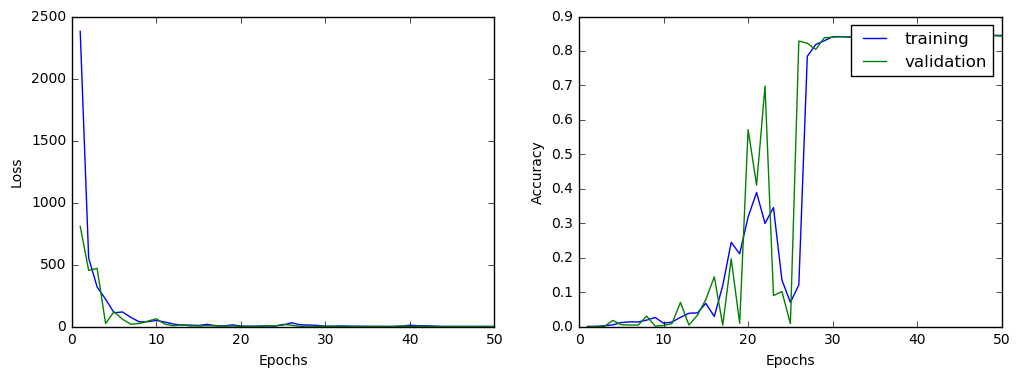

In [74]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), result.history['loss'], label="training")
plt.plot(range(1, num_epochs+1), result.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), result.history['acc'], label="training")
plt.plot(range(1, num_epochs+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [75]:
test_pred_y = model.predict(test_X)

In [76]:
test_pred_y

array([[0.00049554],
       [0.00049554],
       [0.00049554],
       ...,
       [0.00049554],
       [0.00049554],
       [0.00049554]], dtype=float32)

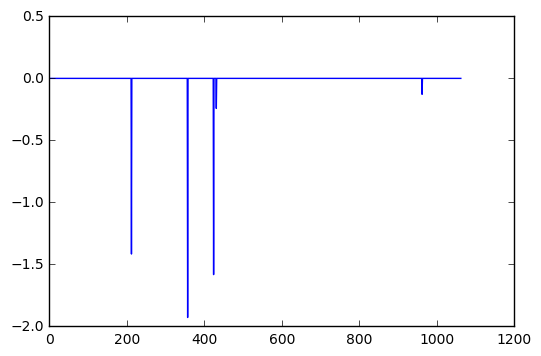

In [77]:
plt.figure()
plt.plot(test_pred_y)
plt.show()